# Пошаговое руководство по обучению модели Neural ODE с использованием BPTT
Pavel Nakaznenko, 2024

Telegram-Канал [То шо нейросети](https://t.me/toshoseti)

## Введение
В этом руководстве мы пошагово рассмотрим процесс обучения модели обыкновенного дифференциального уравнения (ОДУ) с использованием нейронной сети и обратного распространения через время (BPTT). Мы разобьем код на разделы и объясним теорию и детали на каждом этапе.

## Теория
Обыкновенные дифференциальные уравнения (ОДУ) — это уравнения, включающие производные функции. Нейронные ОДУ — это класс моделей, где нейронная сеть определяет производные, позволяя нам моделировать процессы с непрерывным временем.

Мы используем метод Эйлера для численного интегрирования в этом руководстве для простоты. Однако стоит отметить, что более сложные методы, такие как методы Рунге-Кутты или адаптивные решатели (например, метод Дорманда-Принса), могут обеспечить лучшую точность и эффективность.

## Почему BPTT вместо метода сопряженных?
Обратное распространение через время (BPTT) — это техника, используемая для обучения моделей с временными зависимостями. Хотя метод сопряженных часто используется в нейронных ОДУ из-за его эффективности по памяти, BPTT выбран здесь из-за его простой реализации и для иллюстрации концепции более доступным способом.

## Импортируем всякое

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

## Задаем Neural ODE
Здесь мы определяем модель нейронной сети для представления правой части нашего ОДУ.

In [2]:
class ODEFunc(nn.Module):
    """
    Нейронная сеть, моделирующая правую часть ОДУ.
    """
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.ReLU(),
            nn.Linear(50, 2)
        )

    def forward(self, t, y):
        return self.net(y)

## Шаг интегрирования по Эйлеру
Мы используем метод Эйлера для численного интегрирования. Хотя Эйлер прост, он не является самым эффективным или точным методом. Альтернативами являются метод Рунге-Кутты или адаптивные решатели.

In [3]:
def euler_step(func, y, t, dt):
    """
    Выполнить один шаг интегрирования по Эйлеру.
    """
    return y + dt * func(t, y)

## Генерация данных спирали
Мы генерируем синтетические данные спирали с некоторым шумом для обучения и проверки.

In [4]:
def generate_spiral_data(num_step=100, noise_level=0.1):
    """
    Генерация шумных данных спирали.
    """
    t = torch.linspace(0., 25., num_step)
    x = t * torch.sin(t) + noise_level * torch.randn(t.size())
    y = t * torch.cos(t) + noise_level * torch.randn(t.size())
    return torch.stack((x, y), dim=1), t

## Обучение модели
Процесс обучения включает обратное распространение ошибки через время (BPTT) для обработки временных зависимостей в данных.

In [5]:
def train_model(model, optimizer, criterion, train_data, train_times, ode_steps, dt, bptt_steps, epochs, device):
    """
    Функция тренировки ODE модели
    """
    for epoch in range(epochs):
        total_train_loss = 0
        train_y_preds = torch.tensor([]).float().to(device)

        model.train()
        i = 0
        while i < len(train_data['input']):
            optimizer.zero_grad() 
            # Мы аккумулируем loss втечении bptt_steps шагов (backpropagation through time)
            current_loss = 0
            bptt_end = min(i + bptt_steps, len(train_data['input']))

            for b in range(i, bptt_end):
                current_time = train_data['times'][b]
                current_input = train_data['input'][b].detach().requires_grad_(True).to(device)

                # Интегрируем ODE втечении ode_steps шагов
                for _ in range(ode_steps):
                    current_input = euler_step(model, current_input, current_time, dt)
                    current_time += dt

                train_y_preds = torch.cat([train_y_preds, current_input.unsqueeze(0).detach()])
                loss = criterion(current_input, train_data['target'][b].to(device))
                current_loss += loss

            current_loss.backward()  # Обратное распостранение ошибки сквозь время
            optimizer.step()
            total_train_loss += current_loss.item()
            i += bptt_steps

        # Каждые 50 эпох делаем валидацию
        if (epoch % 50 == 0) or (epoch == epochs - 1):
            # Замечание: в качестве изначального значения для валидации передаем последний сэмпл и train датасета
            val_loss, val_y_preds = validate_model(model, criterion, train_data['input'][-1], val_data, ode_steps, dt, device)
            plot_results(data, train_y_preds, val_y_preds)
            print(f'Epoch {epoch}, Train Loss: {total_train_loss / len(train_data["input"])}, Validation Loss: {val_loss / len(val_data["input"])}')

## Проверка модели
Мы проверяем модель, чтобы оценить её производительность на невиданных данных.

In [6]:
def validate_model(model, criterion, initial_input, val_data, ode_steps, dt, device):
    """
    Валидация ODE модели.
    """
    total_val_loss = 0
    val_y_preds = torch.tensor([]).float().to(device)

    model.eval()
    with torch.no_grad():
        current_input = initial_input.detach().to(device)

        for i in range(len(val_data['input'])):
            current_time = val_data['times'][i]

            # Интегрируем ODE втечении ode_steps шагов
            for _ in range(ode_steps):
                current_input = euler_step(model, current_input, current_time, dt)
                current_time += dt

            val_y_preds = torch.cat([val_y_preds, current_input.unsqueeze(0)])
            loss = criterion(current_input, val_data['target'][i].to(device))
            total_val_loss += loss.item()

    return total_val_loss, val_y_preds

## Построение результатов
Наконец, мы визуализируем исходные, тренировочные и проверочные данные.

In [7]:
def plot_results(data, train_y_preds, val_y_preds):
    """
    Plot the original, training, and validation data.
    """
    plt.figure(figsize=(8, 8))
    plt.plot(data[:, 0], data[:, 1], label='Спираль')
    train_y_preds_np = train_y_preds.detach().cpu().numpy()
    val_y_preds_np = val_y_preds.detach().cpu().numpy()
    plt.plot(train_y_preds_np[:, 0], train_y_preds_np[:, 1], 'r--', label='Train предсказания')
    plt.plot(val_y_preds_np[:, 0], val_y_preds_np[:, 1], 'b--', label='Validation предсказания', markersize=12, marker='o')
    plt.legend()
    plt.show()

## Гиперпараметры и генерация данных
Мы определяем гиперпараметры и генерируем данные.

In [8]:
# Гиперпараметры и подготовка данных
epochs = 300
ode_steps = 10
dt = 1 / ode_steps  # Количество шагов интеграции ODE
bptt_steps = 3  # количество шагов для обратного распостранения ошибки сквозь время
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu") # На таком игрушечном примере CPU будет быстрее

data, times = generate_spiral_data()
input_data = data[:-1] # Все данные, кроме последнего сэмпла,
target_data = data[1:] # чтобы мы могли сместить target относительно входов

# Train/validation split
split_index = int(len(input_data) * 0.8)
train_data = {
    'input': input_data[:split_index].to(device),
    'target': target_data[:split_index].to(device),
    'times': times[:split_index].to(device)
}
val_data = {
    'input': input_data[split_index:].to(device),
    'target': target_data[split_index:].to(device),
    'times': times[split_index:].to(device)
}

model = ODEFunc().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.L1Loss() # Замечание: MAE дает более быструю сходимость на данном примере данных

## Training

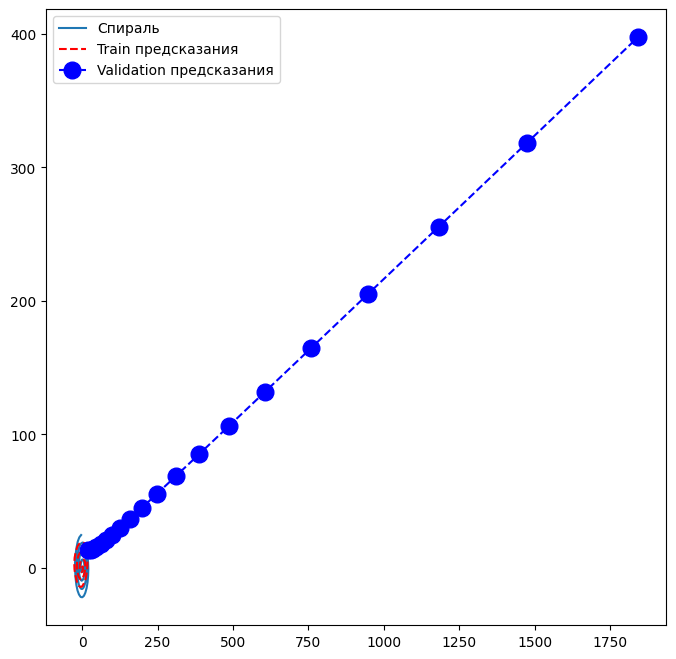

Epoch 0, Train Loss: 2.4064560076103936, Validation Loss: 281.42848467826843


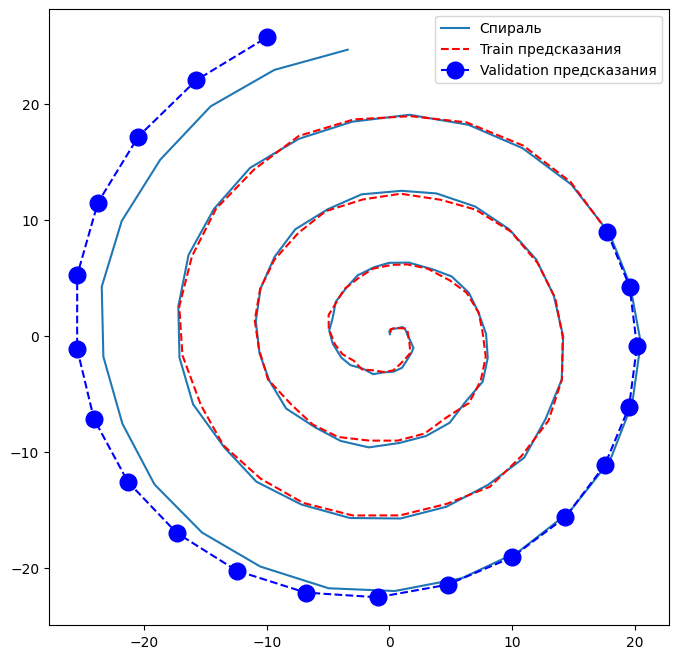

Epoch 50, Train Loss: 0.1716432978835287, Validation Loss: 3.254862666130066


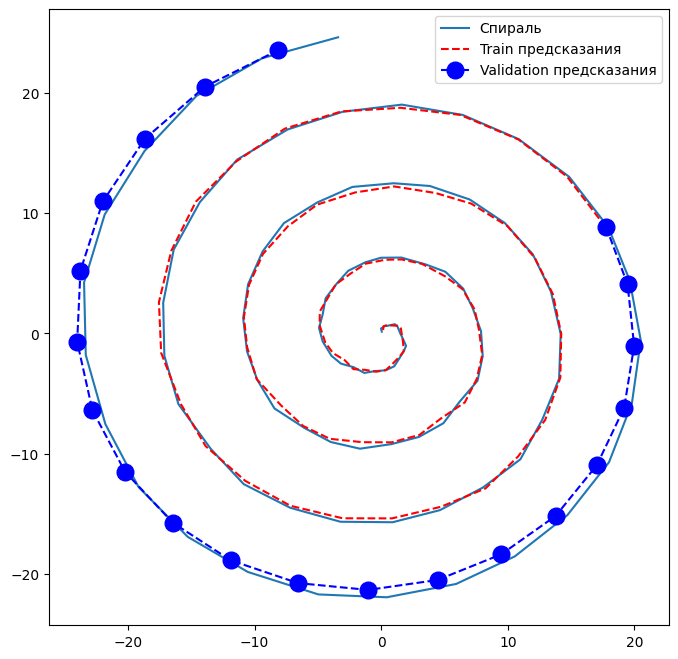

Epoch 100, Train Loss: 0.15850110521799401, Validation Loss: 2.9519740462303163


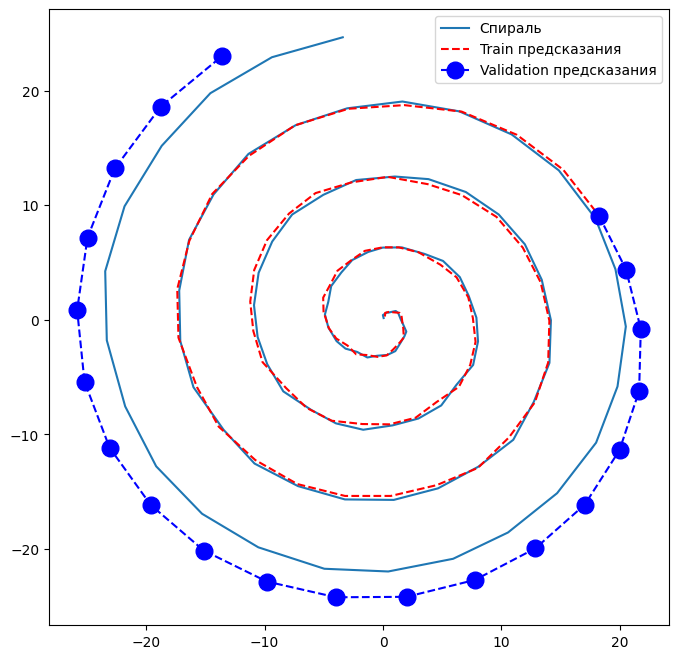

Epoch 150, Train Loss: 0.1841959613787977, Validation Loss: 5.059678983688355


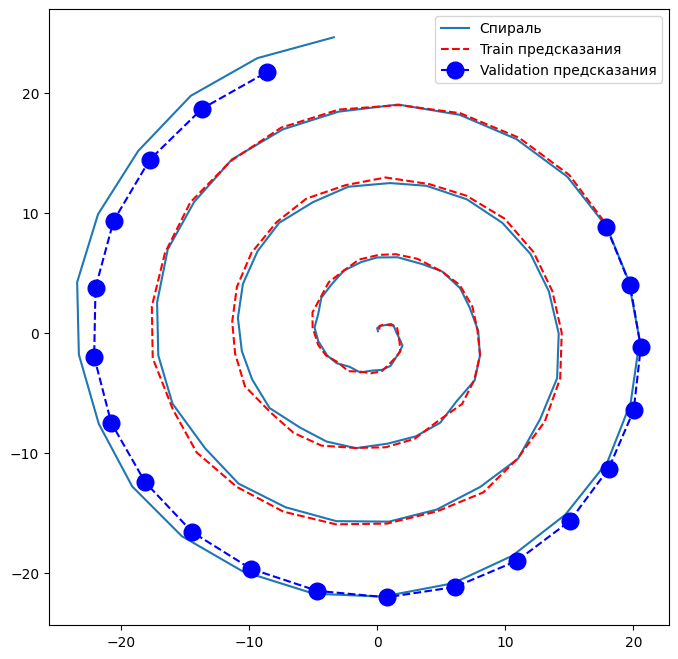

Epoch 200, Train Loss: 0.18844983472099788, Validation Loss: 3.6178356885910032


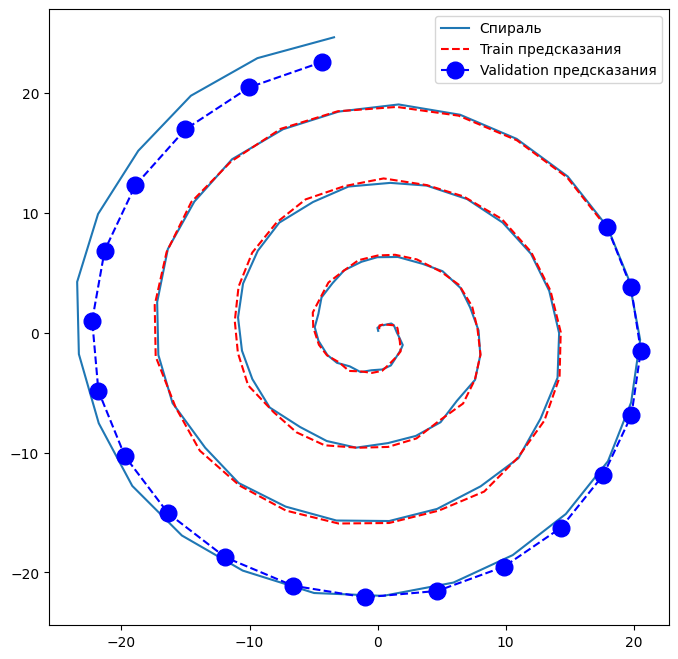

Epoch 250, Train Loss: 0.16567709193199495, Validation Loss: 2.3447609424591063


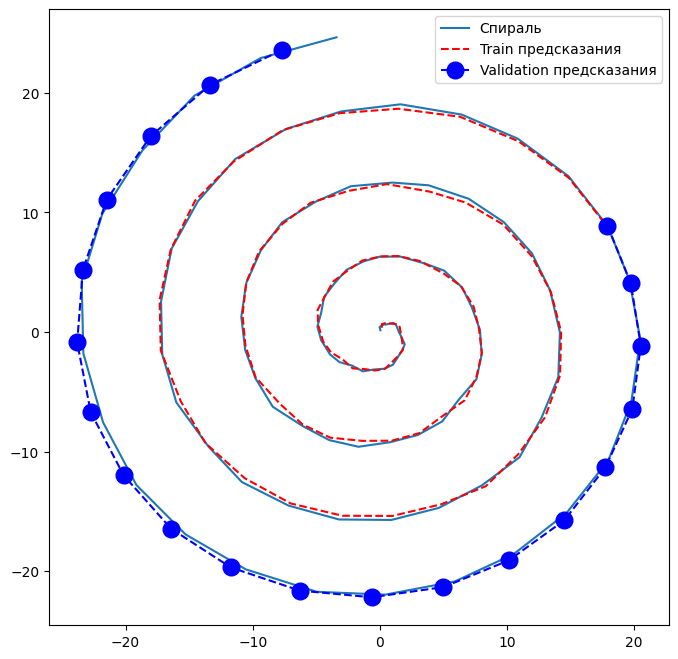

Epoch 299, Train Loss: 0.15735805977748918, Validation Loss: 3.000953459739685


In [9]:
train_model(model, optimizer, criterion, train_data, train_data['times'], ode_steps, dt, bptt_steps, epochs, device)

## Заключение
В этом руководстве мы обучили модель Neural ODE с использованием BPTT. Мы выбрали метод Эйлера для простоты, но для лучшей производительности можно использовать более продвинутые методы.